In [4]:
import pandas as pd
import hvplot.pandas
import geopandas as gpd
import pandas as pd
import requests
import matplotlib.pyplot as plt
import holoviews as hv
from citipy import citipy
import numpy as np
from scipy.stats import linregress
import seaborn as sns
!pip install pandas --upgrade


In [5]:
#load file
electric_vehicle_path = "Electric_Vehicle_Population_Data.csv"

#read file
electric_vehicle_df = pd.read_csv(electric_vehicle_path)

#create dataframe
electric_vehicle_df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Longtitude,Latitude,2020 Census Tract
0,3C3CFFGE4E,Yakima,Yakima,WA,98902.0,2014,FIAT,500,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,87,0,14.0,1593721,-120.524012,46.597394,5.307700e+10
1,5YJXCBE40H,Thurston,Olympia,WA,98513.0,2017,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,200,0,2.0,257167501,-122.817545,46.988760,5.306701e+10
2,3MW39FS03P,King,Renton,WA,98058.0,2023,BMW,330E,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,20,0,11.0,224071816,-122.129888,47.445126,5.303303e+10
3,7PDSGABA8P,Snohomish,Bothell,WA,98012.0,2023,RIVIAN,R1S,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,21.0,260084653,-122.187300,47.820245,5.306105e+10
4,5YJ3E1EB8L,King,Kent,WA,98031.0,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,322,0,33.0,253771913,-122.201252,47.393181,5.303303e+10


In [22]:
num_rows = len(electric_vehicle_df['Make'])
print(num_rows)

166800


In [160]:
#Chatgpt personal communication January 31, 2024
# electric_vehicle_df.dropna(subset=['Legislative District'], inplace=True)
# district_counts = electric_vehicle_df.groupby(['Legislative District', 'Make']).size().reset_index(name='Count')
# print(district_counts.sort_values(by='Count', ascending=False))

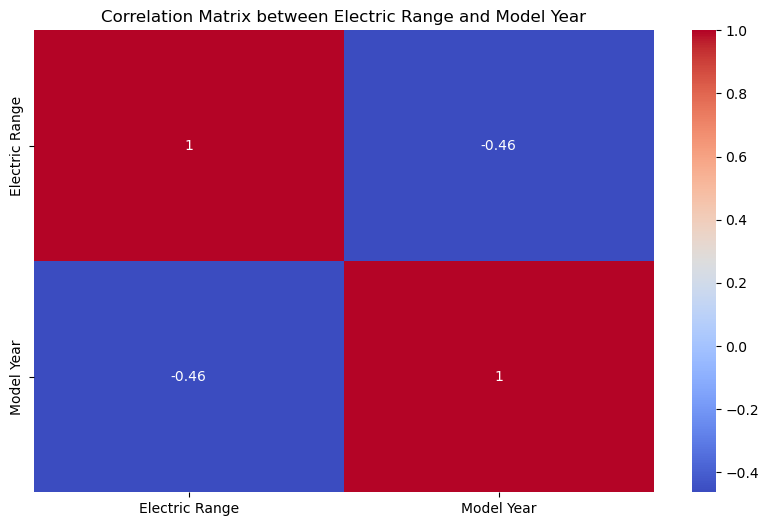

In [28]:
# Data
data = electric_vehicle_df[['Electric Range', 'Model Year']]

# Compute the correlation matrix
correlation_matrix = data.corr()

# Plot
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Matrix between Electric Range and Model Year')
plt.savefig('correlation_range_modelyearpng')
plt.show()

In [8]:
#CLEAN DATAFRAME

#New column
electric_vehicle_df['Legislative District'] = electric_vehicle_df['Legislative District'].astype(str)
electric_vehicle_df['District_Num'] = electric_vehicle_df['Legislative District'].str.extract('(\d+)')

# Legislative district counts
district_counts = electric_vehicle_df['District_Num'].value_counts().reset_index()
district_counts.columns = ['District_Num', 'EV_Count']
district_counts_df = pd.DataFrame(district_counts)

#Chatgpt personal communication January 31, 2024
electric_vehicle_df.replace({'Legislative District': {'NA': np.nan, '': np.nan}}, inplace=True)
electric_vehicle_df.dropna(subset=['Legislative District'], inplace=True)
electric_vehicle_df.dropna(subset=['City'], inplace=True)
electric_vehicle_df.dropna(subset=['County'], inplace=True)

#save file
electric_vehicle_df.to_csv('ev_df.csv', index=False)

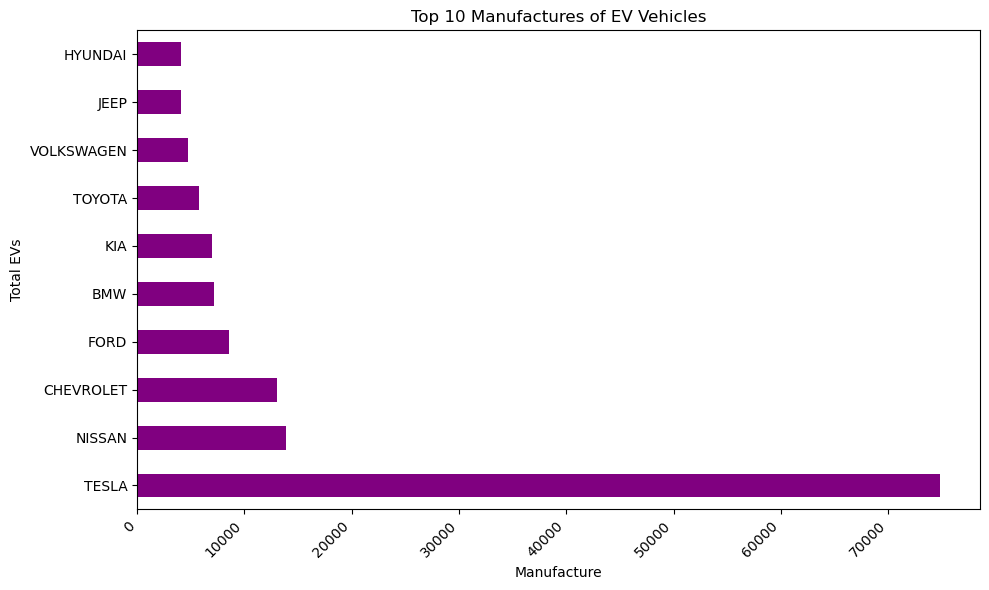

In [63]:
#Matplotlib. Plyplot tutorial. Retrieved from https://matplotlib.org/stable/tutorials/pyplot.html#sphx-glr-tutorials-pyplot-py
#(Accessed on January 25, 2024).

# Group
make_counts = electric_vehicle_df['Make'].value_counts()

# Top 10
top_10 = make_counts.head(10)

# Plot the data
plt.figure(figsize=(10, 6))
top_10.plot(kind='barh', color='purple')
plt.title('Top 10 Manufactures of EV Vehicles')
plt.xlabel('Manufacture')
plt.ylabel('Total EVs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

#Save
plt.savefig('highest_manufacture.png')

plt.show()


In [13]:
# Chatgpt personal communication February 6, 2024
from scipy.stats import chi2_contingency

# Group the data by 'Make' and count the occurrences
make_counts = electric_vehicle_df['Make'].value_counts()

# Select the top manufacturers
top_makes = make_counts.index[:10]

# Filter the DataFrame to include only the top manufacturers
top_manufacturer_df = electric_vehicle_df[electric_vehicle_df['Make'].isin(top_makes)]

# Create a contingency table of Manufacturer vs Total EVs
contingency_table = pd.crosstab(top_manufacturer_df['Make'], columns='Total EVs')

# Compute Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    # Ensure denominator is not zero
    if min((kcorr-1), (rcorr-1)) == 0:
        return 0
    else:
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cramers_v_value = cramers_v(top_manufacturer_df['Make'], top_manufacturer_df.index)

print("Cramer's V:", cramers_v_value)




Cramer's V: 0


C:\Users\miesb\AppData\Local\Temp\ipykernel_23788\3654819843.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='Make', y='Electric Range', data=electric_vehicle_df, palette='bright')


Pearson Correlation Coefficient: 0.07193586773978594


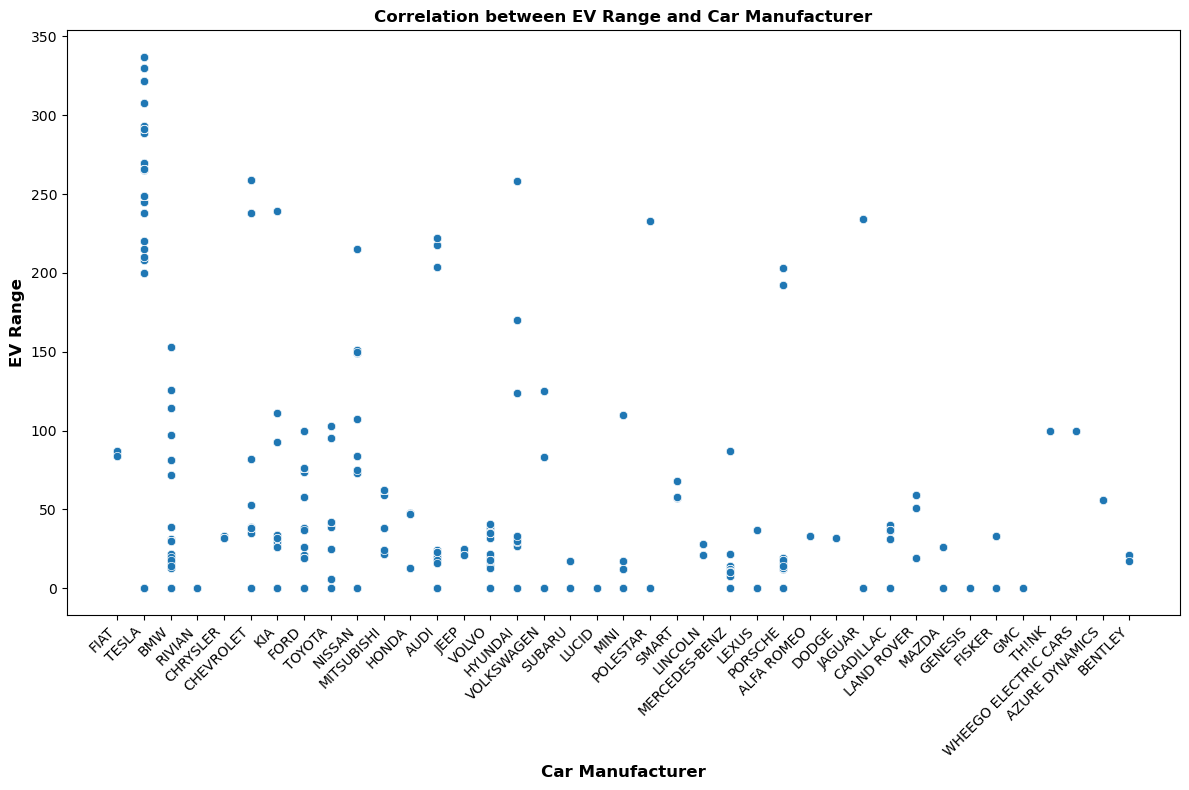

In [33]:
#scatterplot show distribution of ev range for ea manufacture

plt.figure(figsize=(12, 8))
sns.scatterplot(x='Make', y='Electric Range', data=electric_vehicle_df, palette='bright')
plt.title('Correlation between EV Range and Car Manufacturer', weight='bold')
plt.xlabel('Car Manufacturer', fontsize=12, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylabel('EV Range', fontsize=12, weight='bold')
plt.tight_layout()

#Chatgpt personal communication February 6, 2024
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'Make' column
electric_vehicle_df['Make_encoded'] = label_encoder.fit_transform(electric_vehicle_df['Make'])

# Calculate the correlation coefficient
correlation_coefficient = electric_vehicle_df['Electric Range'].corr(electric_vehicle_df['Make_encoded'], method='pearson')
print("Pearson Correlation Coefficient:", correlation_coefficient)

plt.savefig('EV_Range_vs_Car_Manufacturer_Scatterplot.png')
plt.show()



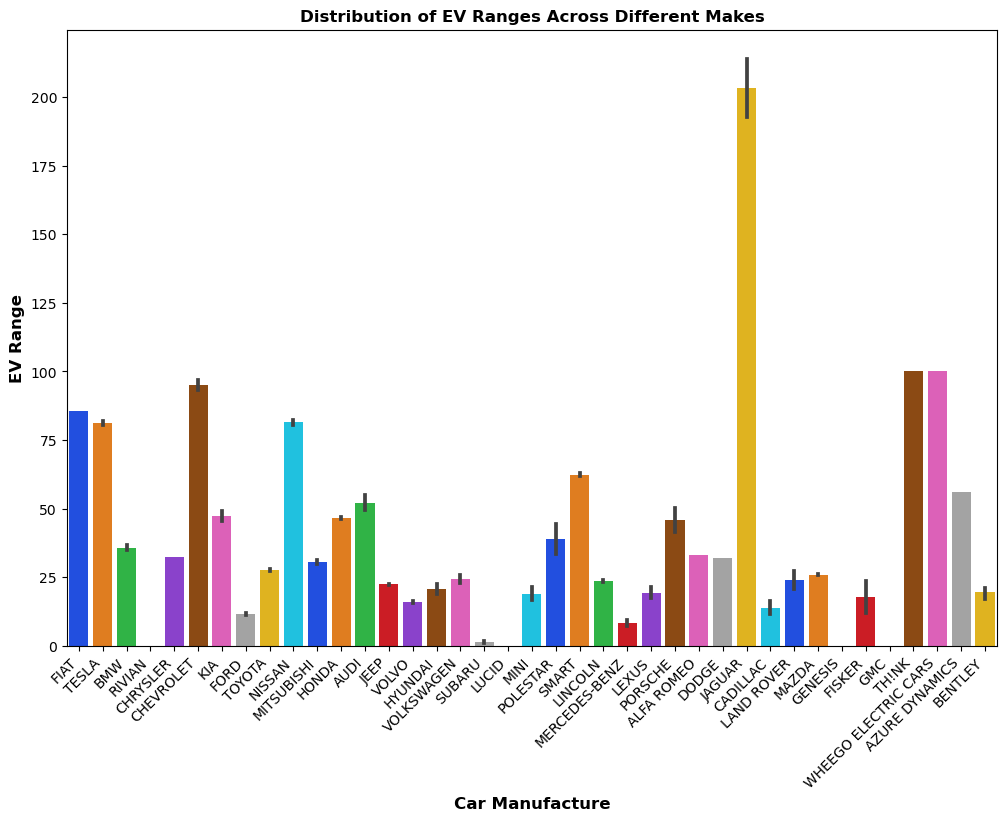

In [34]:
#plot 1 for distribution of EV ranges across different makes

electric_vehicle_df['group_makes'] = electric_vehicle_df['Make']

plt.figure(figsize=(12, 8))
sns.barplot(x='Make', y='Electric Range', data=electric_vehicle_df, palette='bright')
plt.title('Distribution of EV Ranges Across Different Makes', weight='bold')
plt.xlabel('Car Manufacture', fontsize=12, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylabel('EV Range', fontsize=12, weight='bold')


plt.savefig('Distribution_Ranges_Car_Makes_plot1.png')

plt.show()

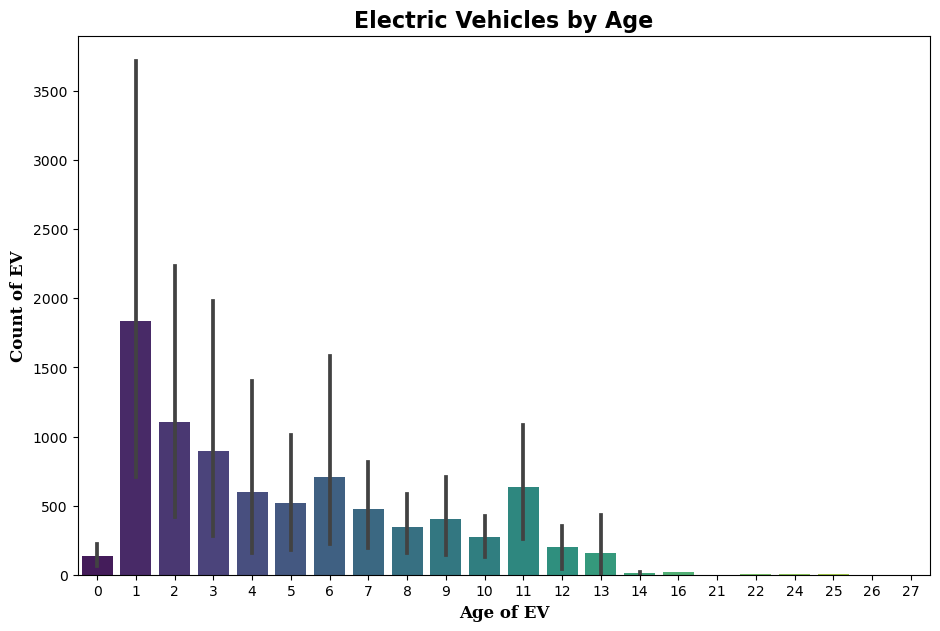

In [35]:
#plot 1 for count of EV by age, make, model

from datetime import datetime

# Age of cars Chatgpt personal communication February 1, 2024
current_year = datetime.now().year
electric_vehicle_df['Age'] = current_year - electric_vehicle_df['Model Year']

# Group by 'Make', 'Model', and 'Age' to get the count Chatgpt personal communication February 1, 2024
grouped_cars_df = electric_vehicle_df.groupby(['Make', 'Model Year', 'Age']).size().reset_index(name='Count')

# Plotting the data
plt.figure(figsize=(11, 7))
sns.barplot(x='Age', y='Count', data=grouped_cars_df, palette='viridis')
plt.title('Electric Vehicles by Age', fontsize=16, weight='bold')
plt.xlabel('Age of EV', fontsize=12, fontfamily='serif', weight='bold')
plt.ylabel('Count of EV', fontfamily='serif', fontsize=12, weight='bold')

#Save
plt.savefig('EV_By_Age_Make_plot1.png')         
          
plt.show()


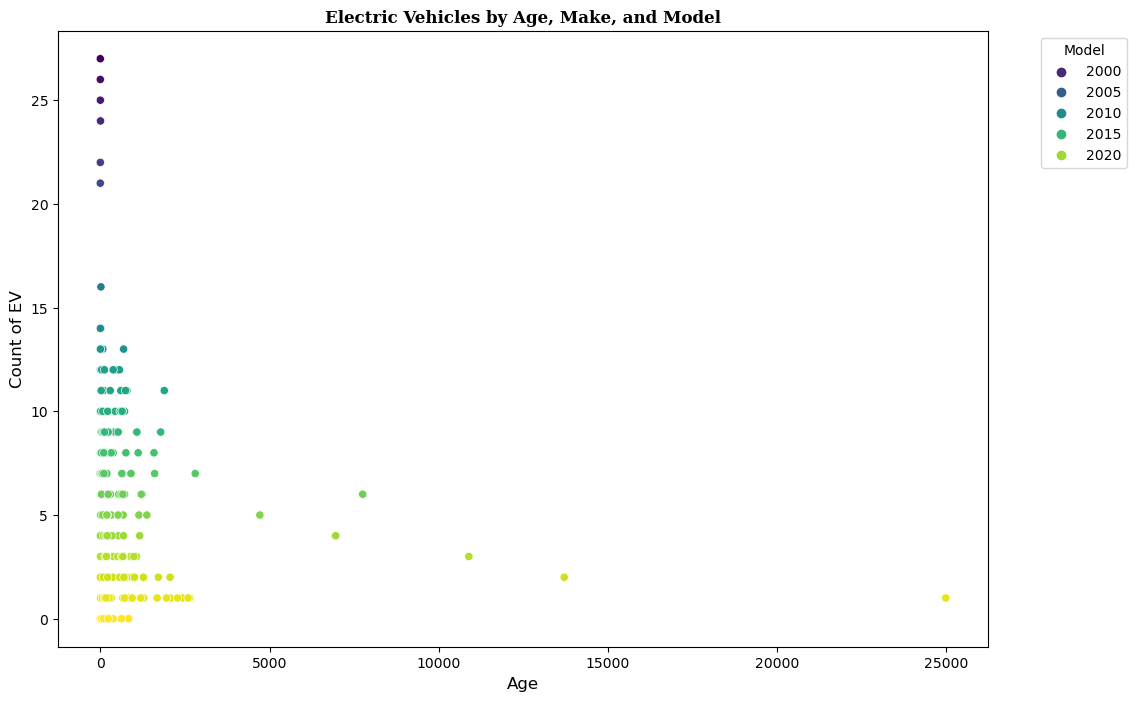

In [36]:
#plt 2 for EV by age, make, model
#!pip install pandas --upgrade
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import datetime

# Addcolumn 'Age' to calculate the age of each vehicle
current_year = datetime.now().year
electric_vehicle_df['Age'] = current_year - electric_vehicle_df['Model Year']

# Group by 'Make', 'Model', and 'Age' to get the count
grouped_cars_df = electric_vehicle_df.groupby(['Make', 'Model Year', 'Age']).size().reset_index(name='Count')

# Plot
plt.figure(figsize=(12, 8)) 
sns.scatterplot(x='Count', y='Age', hue='Model Year', data=grouped_cars_df, palette='viridis')
plt.title('Electric Vehicles by Age, Make, and Model', weight='bold', fontfamily='serif')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count of EV', fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

#Save file
plt.savefig('EV_Count_By_Age_plot2.png')

plt.show()